# Reinforcement Learning for Stock Trading

Welcome to this notebook where we explore how to train a reinforcement learning (RL) agent to trade stocks using real historical data from **Apple Inc. (AAPL)**. We will explore the application of **Q-Learning**, a classical reinforcement learning technique. Our goal is to train an RL agent to make buy, sell, or hold decisions based on technical indicators derived from historical market data.

Our workflow will include:
- Collecting and preprocessing market data
- Engineering meaningful features using technical indicators
- Designing a custom trading environment
- Training and evaluating RL agents

Let's begin by installing and importing the necessary libraries.

In [ ]:
!pip3 install yfinance
!pip3 install numpy
!pip3 install gymnasium
!pip3 install matplotlib

In [1]:
import yfinance as yf
from technical_indicators import technical_indicators
from q_learning import QLearningAgent
from environment import TradingEnv
import numpy as np
import matplotlib.pyplot as plt

seed=42

# Collecting and Preprocessing market data

In this section, we will download historical market data for **Apple Inc. (AAPL)** and preprocess it for use in our Q-Learning environment. This will include generating technical indicators, handling missing values, and preparing the data for training our agent.

In [2]:
df = yf.download("AAPL", start="2015-01-01", end="2024-01-01", multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Let's have a first look at the downloaded data.

In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635290,24.169170,23.448433,24.089088,257142000
2015-01-06,23.637512,23.897778,23.274918,23.699798,263188400
2015-01-07,23.968966,24.069067,23.735393,23.846617,160423600
2015-01-08,24.889902,24.947740,24.180287,24.298187,237458000


Next, we calculate the technical indicators that will serve as the basis for our Q-Learning agent's decision-making process. These indicators include:
- Relative Strength Index (RSI)
- Moving Average Convergence Divergence (MACD)
- Simple Moving Average (SMA) Crossover
- Bollinger Bands
- Stochastic Oscillator (SO)

These indicators will help the agent assess market conditions and make informed trading decisions.

In [4]:
technical_indicators(df=df)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal
Date,,,,,,,,,,,,,,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400,NaN,24.320433,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-05,23.635290,24.169170,23.448433,24.089088,257142000,NaN,24.229080,NaN,NaN,0,NaN,0,-1,NaN,NaN,0,NaN,0
2015-01-06,23.637512,23.897778,23.274918,23.699798,263188400,NaN,24.150205,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-07,23.968966,24.069067,23.735393,23.846617,160423600,NaN,24.126039,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0
2015-01-08,24.889902,24.947740,24.180287,24.298187,237458000,NaN,24.227888,24.090421,NaN,0,NaN,0,1,NaN,NaN,0,NaN,0


Since some of these indicators, like the moving averages, generate NaN values in the initial rows, we drop these rows to ensure the data is clean and ready for use by our agent.

In [5]:
df.dropna(axis=0, how='any', inplace=True)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal
Date,,,,,,,,,,,,,,,,,,
2015-01-30,26.062216,26.693972,25.993255,26.338053,334982000,24.986668,25.041500,25.519879,24.612175,0,58.434388,0,0,26.210716,23.013634,0,86.522464,-1
2015-02-02,26.389217,26.509340,25.821971,26.260198,250956400,25.267846,25.221196,25.765910,24.715614,0,66.039749,0,0,26.492460,22.938769,0,97.909025,-1
2015-02-03,26.393665,26.491542,26.162317,26.360298,207662800,25.488738,25.377525,26.189009,24.853533,0,64.899357,0,0,26.703991,23.003075,0,98.063907,-1
2015-02-04,26.596092,26.807421,26.318030,26.360296,280598800,25.711410,25.540001,26.378091,25.001462,0,66.956301,0,0,26.914579,23.088345,0,100.000000,-1
2015-02-05,26.785921,26.850686,26.631824,26.803786,168984800,25.889667,25.706124,26.445422,25.142310,0,75.500361,1,0,27.147910,23.136709,0,100.000000,-1


As a final preprocessing step, we need to adjust the index of our dataset to match the requirements of our reinforcement learning agent. Specifically, we reset the index so that it starts from 0 and goes up to the length of the dataset. This ensures the agent can properly interact with the environment using a consistent and sequential index.

In [6]:
df['Date'] = df.index
df.reset_index(drop=True, inplace=True)
df.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal,Date
0,26.062216,26.693972,25.993255,26.338053,334982000,24.986668,25.041500,25.519879,24.612175,0,58.434388,0,0,26.210716,23.013634,0,86.522464,-1,2015-01-30
1,26.389217,26.509340,25.821971,26.260198,250956400,25.267846,25.221196,25.765910,24.715614,0,66.039749,0,0,26.492460,22.938769,0,97.909025,-1,2015-02-02
2,26.393665,26.491542,26.162317,26.360298,207662800,25.488738,25.377525,26.189009,24.853533,0,64.899357,0,0,26.703991,23.003075,0,98.063907,-1,2015-02-03
3,26.596092,26.807421,26.318030,26.360296,280598800,25.711410,25.540001,26.378091,25.001462,0,66.956301,0,0,26.914579,23.088345,0,100.000000,-1,2015-02-04
4,26.785921,26.850686,26.631824,26.803786,168984800,25.889667,25.706124,26.445422,25.142310,0,75.500361,1,0,27.147910,23.136709,0,100.000000,-1,2015-02-05


Now that we have preprocessed our market data, including calculating technical indicators and resetting the index, the data is ready to be fed into our Q-Learning agent. We can proceed with training the agent using this cleaned and structured data.

# Training the Q-Learning Agent

To evaluate the performance of our Q-Learning agent, we first need to split the data into a training and testing set. Since we are working with time-series data, it’s important to respect the temporal order of the data to simulate real-world trading conditions, where the agent cannot see future data during training.

We will split the data into 80% for training and 20% for testing.

In [7]:
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]
test_data.reset_index(drop=True, inplace=True)
test_data.head()

,Close,High,Low,Open,Volume,SMA,EMA,SMA_short,SMA_long,Crossover_signal,RSI,RSI_signal,MACD_signal,Upper_Band,Lower_Band,BB_signal,Stochastic_Osc,SO_signal,Date
0,161.365311,161.857338,157.212598,157.950639,123511700,155.760136,157.895655,155.460986,158.747732,0,48.749995,0,1,167.440827,150.054637,0,83.814192,-1,2022-03-18
1,162.742996,163.697531,160.410776,160.902803,95811400,156.358444,158.541967,158.365915,158.653263,0,52.417935,0,0,167.115087,150.191439,0,92.597183,-1,2022-03-21
2,166.128143,166.718567,162.280485,162.870909,81532000,157.478299,159.553457,161.068130,158.874673,1,52.502205,0,0,167.886045,149.863302,0,100.000000,-1,2022-03-22
3,167.495987,169.887233,164.976794,165.311384,98062700,158.192726,160.612461,163.158264,159.373589,0,54.305495,0,0,169.141745,149.605432,0,100.000000,-1,2022-03-23
4,171.294434,171.363310,167.495981,168.332419,90131400,159.722931,162.036724,165.805374,159.931057,0,61.590845,0,0,171.062105,148.800008,-1,100.000000,-1,2022-03-24


First, we set up our trading environment.

In [8]:
env = TradingEnv(data=train_data, initial_cash=10000, max_num_shares=100, max_short_position=100, cost_per_trade=0)
env.action_space.seed(seed)

42

Next, we initialize our Q-Learning agent and train it on our train data.

In [9]:
agent = QLearningAgent(action_space=env.action_space, observation_space=env.observation_space)
agent.train(env=env, num_episodes=1000)

Episode 1000/1000, Epsilon: 0.010
Training finished!


# Evaluating the Q-Learning Agent on the Training Set

In this section, we evaluate the performance of our agent on the training set and compare it to the performance of a random strategy.

In [10]:
state, _ = env.reset(seed=seed)

Next, we evaluate our agent on the training set. To do this, we will set epsilon to zero, meaning that the agent will no longer explore randomly but will instead always choose the action that maximizes the Q-values (pure exploitation of the learned policy).


In [11]:
agent.epsilon = 0
done = False
portfolio_value = np.zeros(len(train_data)-1)
i = 0
while not done:
    action = agent.get_action(state)
    state, _, done, _ = env.step(action)
    portfolio_value[i] = env.portfolio_value
    # print(f"Position:  {env.current_position}, Portfolio value: {env.portfolio_value}")
    i+=1

Text(0.5, 1.0, 'Q-Learning agent (Train Set)')

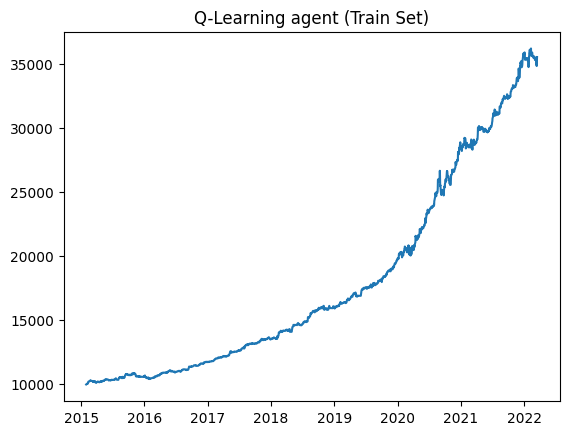

In [12]:
plt.plot(list(train_data["Date"][:-1]), portfolio_value)
plt.title('Q-Learning agent (Train Set)')

Next, we compare our strategy to a random strategy.

In [13]:
env.reset(seed=seed)
done = False
portfolio_value_random_strategy = []
i = 0
while not done:
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    portfolio_value_random_strategy.append(env.portfolio_value)
    # print(f"Position:  {env.current_position}, Portfolio value: {env.portfolio_value}")
    i+=1

Text(0.5, 1.0, 'Random Strategy (Train Set)')

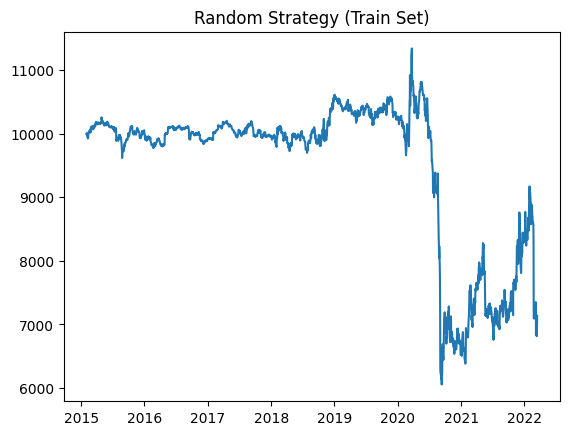

In [14]:
plt.plot(list(train_data["Date"][:-1]), portfolio_value_random_strategy)
plt.title('Random Strategy (Train Set)')

# Evaluating the Q-Learning Agent on the Test Set

In this section, we evaluate the Q-Learning Agent on the Test Set. To this end, we first initialiaze a new Trading environment, using the test data.

In [15]:
test_env = TradingEnv(data=test_data, initial_cash=10000, max_num_shares=100, max_short_position=100, cost_per_trade=0)
test_env.action_space.seed(123)

123

Next, we evaluate the performance of our Q-Learning Agent on the test set.

In [16]:
state, _ = test_env.reset(seed=seed)
agent.epsilon = 0
done = False
portfolio_value_test = np.zeros(len(test_data)-1)
i = 0
while not done:
    action = agent.get_action(state)
    state, _, done, _ = test_env.step(action)
    portfolio_value_test[i] = test_env.portfolio_value
    # print(f"Position:  {test_env.current_position}, Portfolio value: {test_env.portfolio_value}")
    i+=1

Text(0.5, 1.0, 'Q-Learning agent (Train Set)')

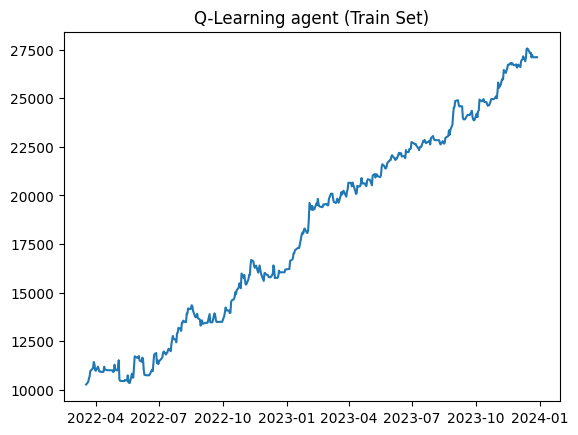

In [17]:
plt.plot(list(test_data["Date"][:-1]), portfolio_value_test)
plt.title('Q-Learning agent (Train Set)')

We compare the performance of our Q-Learning agent to the performance of a simple buy-and-hold strategy of the underlying asset over the same time period.

Text(0.5, 1.0, 'Apple (AAPL)')

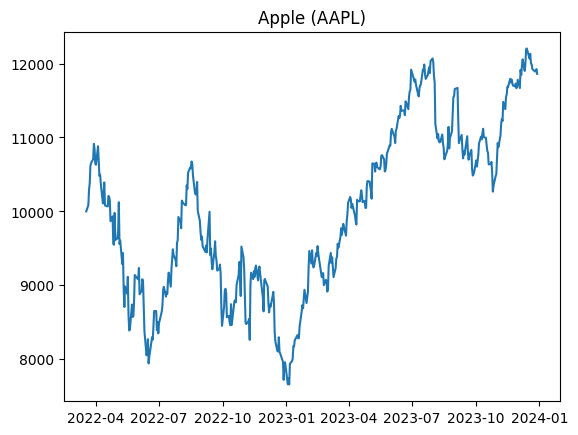

In [19]:
initial_num_shares = 10000/test_data["Close"][0]
plt.plot(test_data['Date'],test_data['Close']*initial_num_shares)
plt.title("Apple (AAPL)")

Finally, we compare the performance of the Q-Learning agent to that of a random strategy over the same period.

In [20]:
test_env.reset(seed=seed)
done = False
portfolio_value_random_strategy_test = []
i = 0
while not done:
    action = env.action_space.sample()
    state, _, done, _ = test_env.step(action)
    portfolio_value_random_strategy_test.append(test_env.portfolio_value)
    # print(f"Position:  {test_env.current_position}, Portfolio value: {test_env.portfolio_value}")
    i+=1

Text(0.5, 1.0, 'Random Strategy (Test Set)')

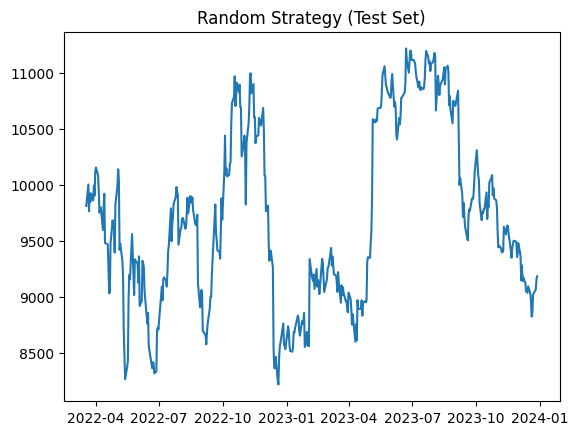

In [21]:
plt.plot(list(test_data["Date"][:-1]), portfolio_value_random_strategy_test)
plt.title('Random Strategy (Test Set)')